## Fagitue damage application

This is an application of fatigue damage calculation with generated load sequence for a 300CVM steel.

Material properties: yield stress $\sigma_{y} = 2098$ MPa and ultimate stress $\sigma_{u} =2590$ MPa. 

Number of cycles to failure at different stress amplitudes is given below. 

<!-- | Stress amplitude (MPa) | 2086 | 2000 | 1655 |  1103  |   965   |   900   |   827   |
|------------------------|------|------|------|--------|---------|---------|---------|
| Fatigue life           | 891  | 1160 | 3809 | 48,645 | 112,573 | 174,400 | 296,400 |
 -->

| Stress amplitude (MPa) |  Fatigue life  |
|------------------------|----------------|
|          2086          |     891        |
|          2000          |     1,160      |
|          1655          |     3,809      |
|          1103          |     48,645     |
|          965           |     112,573    |
|          900           |     174,400    |
|          827           |     296,400    |


Reference: 

- Manson, S.S., Freche, J.C. and Ensign, C.R., 1967. Application of a double linear damage rule to cumulative fatigue (Vol. 3839). National Aeronautics and Space Administration.

In [1]:
# Import auxiliary libraries for demonstration

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams[ "figure.figsize" ] = [ 5, 4 ]

plt.rcParams[ "figure.dpi" ] = 80
plt.rcParams[ "font.family" ] = "Times New Roman"
plt.rcParams[ "font.size" ] = '14'

In [2]:
# Set random seed for repeatable results
from ffpack.config import globalConfig

globalConfig.setSeed( 2023 )

### Material properties 

In [3]:
ultimateStrength = 2590

snData = [ [ 891, 2086 ], [ 1160, 2000 ], [ 3809, 1655 ], [ 48645, 1103 ], 
           [ 112573, 965 ], [ 174400, 900 ], [ 296400, 827 ] ]

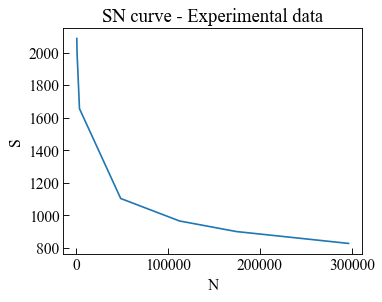

In [4]:
fig, ax = plt.subplots()

ax.plot( np.array( snData )[:,0], np.array( snData )[:,1] )

ax.tick_params(axis='x', direction="in", length=5)
ax.tick_params(axis='y', direction="in", length=5)
ax.set_ylabel( "S" )
ax.set_xlabel( "N" )
ax.set_title( "SN curve - Experimental data" )

plt.tight_layout()
plt.show()

### Generate load sequence data

The load sequence data is generated with a second order ARMA model. The initial observation values, the coefficients for autoregressive and moving average, the normal distribution coefficients for white noise are assumed. 

In [5]:
# second order ARMA model
from ffpack.lsg import armaNormal

numStep = 1000
obs = [ 1000, 1200 ]
phis = [ 0.4, 0.2 ]
thetas = [ 0.8, 0.5 ]
mu = 200
sigma = 500 
arman2ndResults = armaNormal( numStep, obs, phis, thetas, mu, sigma )

In [6]:
# filer stresses greater than ultimate stress and those below 0 for processing
arman2ndResults = [x for x in arman2ndResults if x < 2590 and x > 0 ]

In [7]:
len(arman2ndResults)

748

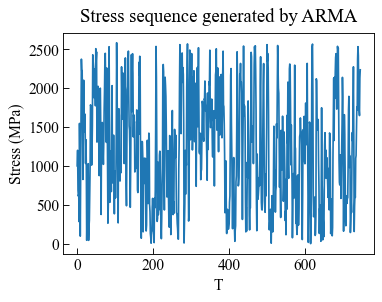

In [8]:
fig, ax = plt.subplots()

ax.plot( np.array( arman2ndResults ) )

ax.tick_params(axis='x', direction="in", length=5)
ax.tick_params(axis='y', direction="in", length=5)
ax.set_ylabel( "Stress (MPa)" )
ax.set_xlabel( "T" )
ax.set_title( "Stress sequence generated by ARMA", pad=10 )

plt.tight_layout()
plt.show()

### Digitize sequence

The generated sequence is digitized with a resolution of 100 MPa. 

In [9]:
from ffpack.utils import sequenceDigitization

dstrResults = sequenceDigitization( arman2ndResults, resolution=100 )

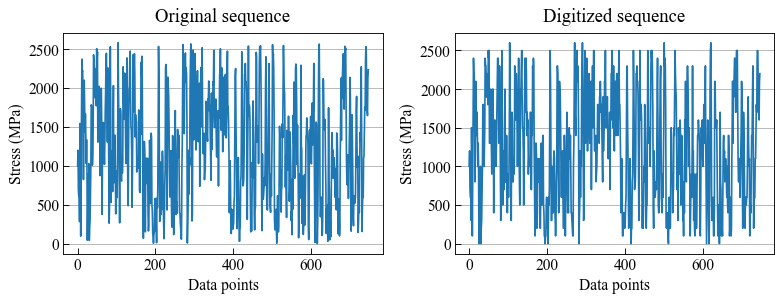

In [10]:
fig, ( ax1, ax2 ) = plt.subplots( 1, 2, figsize=( 10, 4 ) )

ax1.plot( arman2ndResults, '-' )

ax1.tick_params( axis='x', direction="in", length=5 )
ax1.tick_params( axis='y', direction="in", length=5 )
ax1.set_ylabel( "Stress (MPa)" )
ax1.set_xlabel( "Data points" )
ax1.set_title( "Original sequence", pad=10 )
ax1.grid( axis='y', color="0.7" )

ax2.plot( dstrResults, '-' )

ax2.tick_params(axis='x', direction="in", length=5)
ax2.tick_params(axis='y', direction="in", length=5)
ax2.set_ylabel( "Stress (MPa)" )
ax2.set_xlabel( "Data points" )
ax2.set_title( "Digitized sequence", pad=10 )
ax2.grid( axis='y', color="0.7" )

plt.tight_layout()
plt.show()

### Filtering

The digitized sequence is firstly filtered using the ``sequencePeakValleyFilter`` to retain only the peek and valley values. The resulting sequence is further filtered using the ``sequenceHysteresisFilter`` to eliminate small vibrations. 

In [11]:
from ffpack.utils import sequencePeakValleyFilter

gspvResults = sequencePeakValleyFilter( dstrResults, keepEnds=True )

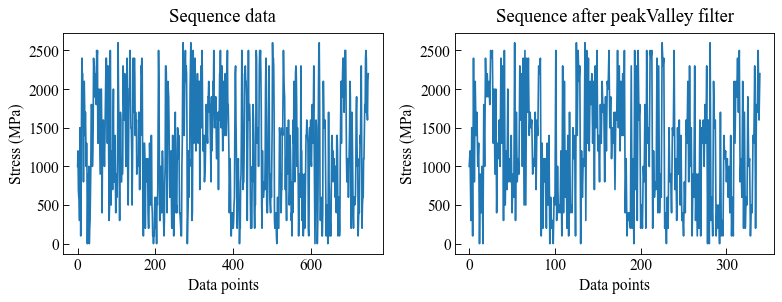

In [12]:
fig, ( ax1, ax2 ) = plt.subplots( 1, 2, figsize=( 10, 4 ) )

ax1.plot( dstrResults, '-' )

ax1.tick_params( axis='x', direction="in", length=5 )
ax1.tick_params( axis='y', direction="in", length=5 )
ax1.set_ylabel( "Stress (MPa)" )
ax1.set_xlabel( "Data points" )
ax1.set_title( "Sequence data", pad=10 )

ax2.plot( gspvResults, '-' )

ax2.tick_params(axis='x', direction="in", length=5)
ax2.tick_params(axis='y', direction="in", length=5)
ax2.set_ylabel( "Stress (MPa)" )
ax2.set_xlabel( "Data points" )
ax2.set_title( "Sequence after peakValley filter", pad=10 )

plt.tight_layout()
plt.show()

In [13]:
from ffpack.utils import sequenceHysteresisFilter

gateSize = 500   # assumed
hfResults = sequenceHysteresisFilter( gspvResults, gateSize )

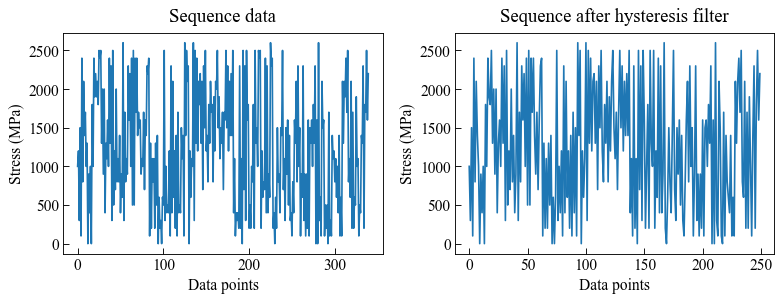

In [14]:
fig, ( ax1, ax2 ) = plt.subplots( 1, 2, figsize=( 10, 4 ) )

ax1.plot( gspvResults, '-' )

ax1.tick_params( axis='x', direction="in", length=5 )
ax1.tick_params( axis='y', direction="in", length=5 )
ax1.set_ylabel( "Stress (MPa)" )
ax1.set_xlabel( "Data points" )
ax1.set_title( "Sequence data", pad=10 )

ax2.plot( hfResults, '-' )

ax2.tick_params(axis='x', direction="in", length=5)
ax2.tick_params(axis='y', direction="in", length=5)
ax2.set_ylabel( "Stress (MPa)" )
ax2.set_xlabel( "Data points" )
ax2.set_title( "Sequence after hysteresis filter", pad=10 )

plt.tight_layout()
plt.show()

### Rainflow counting and mean stress correction

After filtering, the stress sequence is processed using the ``astmRainflowCounting`` method to obtain the cycle counts. To account for the impact of the superimposed tensile stress, the stresses are corrected using the ``goodmanCorrection`` method. The results are saved in both non-corrected and corrected forms for later fatigue damage evaluation.

In [15]:
from ffpack.lcc import astmRainflowCounting

astmRfcCountingRaw = astmRainflowCounting( hfResults, aggregate=False )

astmRfcCountingRaw[:6][:]

[[1000.0, 300.0, 0.5],
 [300.0, 1500.0, 0.5],
 [1500.0, 100.0, 0.5],
 [800.0, 2100.0, 1],
 [100.0, 2400.0, 0.5],
 [900.0, 400.0, 1]]

In [16]:
# show stress amplitude for rainflow counting result

astmRfcCountingAmp = []
for row in astmRfcCountingRaw:
    astmRfcCountingAmp.append([abs(row[0] - row[1])/2, row[2]])
    
astmRfcCountingAmp[:6][:]

[[350.0, 0.5],
 [600.0, 0.5],
 [700.0, 0.5],
 [650.0, 1],
 [1150.0, 0.5],
 [250.0, 1]]

In [17]:
# mean stress correction
from ffpack.lcc import goodmanCorrection

goodmanCorrected = []

for i in range(0, len(astmRfcCountingRaw)):
    stressRangeData = astmRfcCountingRaw[i][:2]
    if stressRangeData[0] > stressRangeData[1]:
        temp = stressRangeData[0]
        stressRangeData[0] = stressRangeData[1]
        stressRangeData[1] = temp
    goodmanResult = goodmanCorrection( stressRangeData, ultimateStrength )
    goodmanCorrected.append([goodmanResult, astmRfcCountingRaw[i][2] ])

In [18]:
goodmanCorrected[:6][:]

[[467.2680412371134, 0.5],
 [919.5266272189349, 0.5],
 [1012.8491620111732, 0.5],
 [1476.7543859649122, 1],
 [2222.7611940298502, 0.5],
 [333.7628865979381, 1]]

The stress amplitudes in each row of the corrected result, named ``goodmanCorrected``, are larger than the original amplitudes in  ``astmRfcCountingAmp``.

In [19]:
# rainflow counting results after aggregation
astmRfcCountingResults = astmRainflowCounting( hfResults )
astmRfcCountingResults

[[500.0, 6.0],
 [600.0, 13.5],
 [700.0, 7.5],
 [800.0, 8.0],
 [900.0, 5.5],
 [1000.0, 4.0],
 [1100.0, 6.0],
 [1200.0, 1.5],
 [1300.0, 8.0],
 [1400.0, 0.5],
 [1500.0, 5.0],
 [1600.0, 5.0],
 [1700.0, 4.0],
 [1800.0, 2.0],
 [1900.0, 3.0],
 [2000.0, 3.0],
 [2100.0, 2.0],
 [2200.0, 9.0],
 [2300.0, 2.5],
 [2400.0, 2.5],
 [2500.0, 1.5],
 [2600.0, 5.0]]

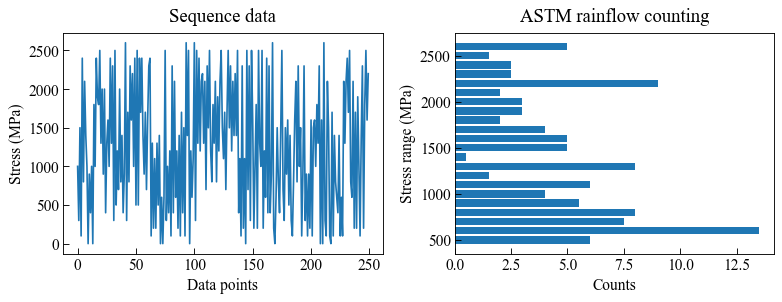

In [20]:
fig, ( ax1, ax2 ) = plt.subplots( 1, 2, figsize=( 10, 4 ) )

ax1.plot( hfResults, "-" )

ax1.tick_params( axis='x', direction="in", length=5 )
ax1.tick_params( axis='y', direction="in", length=5 )
ax1.set_ylabel( "Stress (MPa)" )
ax1.set_xlabel( "Data points" )
ax1.set_title( "Sequence data", pad=10 )

arr_str = np.array( astmRfcCountingResults )[ :, 0 ].astype(int).astype(str)
ax2.barh( arr_str,
          np.array( astmRfcCountingResults )[ :, 1 ] )

# show tick labels every 5
from matplotlib.ticker import MultipleLocator
ax2.yaxis.set_major_locator(MultipleLocator(5))

ax2.tick_params( axis='x', direction="in", length=5 )
ax2.tick_params( axis='y', direction="in", length=5 )
ax2.set_ylabel( "Stress range (MPa)" )
ax2.set_xlabel( "Counts" )
ax2.set_title( "ASTM rainflow counting", pad=10 )

plt.tight_layout()
plt.show()

### Rainflow counting matrix

In [21]:
from ffpack.lsm import astmRainflowCountingMatrix

arcmMat, arcmIndex = astmRainflowCountingMatrix( hfResults )

arcmMat = np.array( arcmMat )
arcmIndex = np.array([s.replace(',', '') for s in arcmIndex]).astype(float)

In [22]:
print( "ASTM rainflow counting matrix" )
print( arcmMat )
print()
print( "Matrix index" )
print( arcmIndex )

ASTM rainflow counting matrix
[[0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.
  0.  0.  0.  0.  0.  0.  0.  1.5 2.5]
 [0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  2.  0.  1.  1.
  0.  0.  0.  1.  0.  5.  0.5 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  2.  0.  0.  1.  0.  0.  1.
  1.  1.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  1.  0.  0.  0.5 1.  0.
  0.  0.  0.  0.  0.  0.  0.  2.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.
  0.  0.  0.  1.  0.  1.  1.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.
  0.  0.  1.  0.  0.  0.  1.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.
  0.  0.  0.  1.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  1.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.
 

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  from ipykernel import kernelapp as app
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  


<Figure size 400x320 with 0 Axes>

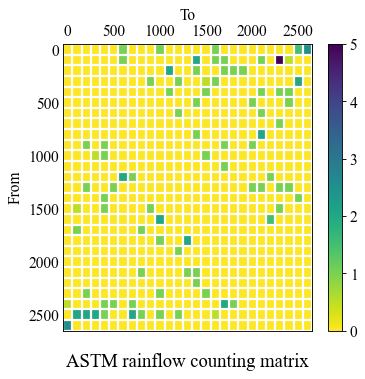

In [23]:
plt.set_cmap( "viridis_r")
fig, ax = plt.subplots(figsize=( 5, 5 ))

cax = ax.matshow( arcmMat )

ax.tick_params( axis='x', direction="in", length=5, top=False, bottom=False )
ax.tick_params( axis='y', direction="in", length=5, left=False, right=False )
ax.tick_params( axis='x', which="minor", top=False, bottom=False )
ax.tick_params( axis='y', which="minor", left=False, right=False )

# show tick labels every 5
from matplotlib.ticker import MultipleLocator
ax.yaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.set_xticklabels( [ '' ] + arcmIndex.astype(int)[::5].tolist() )
ax.set_yticklabels( [ '' ] + arcmIndex.astype(int)[::5].tolist() )

# show every tick
ax.set_xticks( np.arange( -.5, len( arcmIndex ), 1 ), minor=True )
ax.set_yticks( np.arange( -.5, len( arcmIndex ), 1 ), minor=True )
ax.grid( which="minor", color='w', linestyle='-', linewidth=2 )

ax.set_ylabel( "From" )
ax.set_xlabel( "To" )
ax.xaxis.set_label_position( "top" )
ax.set_title( "ASTM rainflow counting matrix", y=-0.15 )

ax.set_aspect('auto')
fig.colorbar( cax )
plt.tight_layout()
plt.show()

### Fatigue damage model

Classic Palmgren-miner damage model is used to evaluate the fatigue limit under the loading sequence. 

In [24]:
from ffpack.fdm import minerDamageModelClassic

# use non-corrected stresses
import copy
cmdrLccData = copy.deepcopy(astmRfcCountingResults)
# change the stress range in rainflow counting result to stress amplitute
for row in cmdrLccData:
    row[0] /= 2

cmdrSnData = snData
cmdrFatigueLimit = 50

cmdrResults = minerDamageModelClassic( cmdrLccData, cmdrSnData, cmdrFatigueLimit )

In [25]:
print( "{:.4f}".format(cmdrResults) )

0.0007


In [26]:
# use goodman corrected stresses

cmdrLccData = goodmanCorrected
cmdrSnData = snData
cmdrFatigueLimit = 50

cmdrResults = minerDamageModelClassic( cmdrLccData, cmdrSnData, cmdrFatigueLimit )

In [27]:
print( "{:.4f}".format(cmdrResults) )

0.1822


The application of the Goodman correction on the stresses resulted in a higher calculated fatigue limit compared to the non-corrected stresses. This implies that the presence of superimposed static stress increases the fatigue damage.